This notebook follows an exercise from the Module on Autoencoders from the [IBM Course on Deep Learning and Reinforcement Learning](https://www.coursera.org/learn/deep-learning-reinforcement-learning?specialization=ibm-machine-learning), part of the [IBM Machine Learning Professional Certification](https://www.coursera.org/professional-certificates/ibm-machine-learning).

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd "/content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/autoencoders"
file_prefix = %pwd

/content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/autoencoders


In [3]:
!pip install pyyaml h5py

In [22]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from keras import Sequential
from keras.datasets import mnist, fashion_mnist
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Reshape, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [5]:
learning_rate = 0.001

In [48]:
def loss_plot(history, title = None):
  fig = plt.figure(figsize = (6,10))
  ax = plt.subplot(2,1,1)
  ax.plot(history["loss"], color = "blue", label = "training loss")
  ax.plot(history["val_loss"], color = "orange", label = "validation loss")
  ax.set_xlabel("epochs")
  ax.set_ylabel("loss")
  ax.legend()
  ax.set_title(title)
  plt.show()
  return fig, ax

def plot_rand_images(ref_imgs,
                     recr_imgs,
                     num_rand = 4,
                     ref_size = [28, 28],
                     recr_size = [28, 28]):
  # reshape image if necessary
  if len(ref_imgs.shape) == 2:
    new_size_ref = [ref_imgs.shape[0]] + ref_size
    new_size_recr = [recr_imgs.shape[0]] + recr_size
    ref_imgs = ref_imgs.reshape(new_size_ref)
    recr_imgs = recr_imgs.reshape(new_size_recr)
  # select four random indices for images to plot
  indices = [np.random.choice(np.arange(0, ref_imgs.shape[0])) for i in range(num_rand)]
  # plot reference and recreated images
  for i in range(num_rand):
    ax = plt.subplot(2, num_rand, i + 1)
    plt.imshow(ref_imgs[indices[i], : ,:], cmap = "gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, num_rand, i + 1 + num_rand)
    plt.imshow(recr_imgs[indices[i], : ,:], cmap = "gray")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()
  return None

# Shallow Autoencoder

## Functional API

We begin by building a simple shallow autoencoder using the Keras functional API and training this on MNIST data.

In [7]:
encoder_dim = 36 # dimension we will use for our latent representation
batch_size = 256
epochs = 25
optimizer = Adam(learning_rate = learning_rate)
file_name = "autoencoder_ae1" # name to save model weights, history under

In [8]:
# import the data:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# normalize the image data:
X_train = X_train.astype("float32")/255.
X_test = X_test.astype("float32")/255.
# reshape image matrices into vectors -- this is appropriate because we are
# using dense layers -- rather than CNNS -- for our encoder and decoder
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))
print(X_train.shape)
print(X_test.shape)
image_dim = np.prod(X_train.shape[1:])

(60000, 784)
(10000, 784)


We see that our images are now stored as vectors of length $28 \times 28 = 784$.

In [9]:
def functional_shallow_autoencoder(image_dim, encoder_dim, optimizer):
  input = Input(shape = (image_dim,))
  encoder = Dense(units = encoder_dim, activation = "relu")(input)
  decoder = Dense(units = image_dim, activation = "sigmoid")(encoder)
  model = Model(inputs = input, outputs = decoder)
  model.compile(optimizer = optimizer,
                loss = "binary_crossentropy")
  return model
  # note that we use binary rather than categorical cross entropy because
  # we are attempting to recreate the input images not classify them

In [10]:
model = functional_shallow_autoencoder(image_dim, encoder_dim, optimizer)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 36)                  │          28,260 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 784)                 │          29,008 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57,268 (223.70 KB)

 Trainable params: 57,268 (223.70 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
checkpoint_path = file_prefix + "/checkpoints/" + file_name + ".weights.h5"
cp_callback = ModelCheckpoint(filepath = checkpoint_path,
                              save_weights_only = True,
                              verbose = 1)

In [12]:
history = model.fit(X_train,
                    X_train,
                    epochs = epochs,
                    batch_size = batch_size,
                    shuffle = True,
                    validation_data = (X_test, X_test),
                    callbacks = [cp_callback])

Epoch 1/25
233/235 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.3766
Epoch 1: saving model to /content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/autoencoders/checkpoints/autoencoder_ae1.weights.h5
235/235 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.3752 - val_loss: 0.1818
Epoch 2/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1726
Epoch 2: saving model to /content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/autoencoders/checkpoints/autoencoder_ae1.weights.h5
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 0.1726 - val_loss: 0.1466
Epoch 3/25
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.1429
Epoch 3: saving model to /content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/autoencoders/checkpoints/autoencoder_ae1.weights.h5
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 31

In [13]:
save_path = file_prefix + "/checkpoints/" + file_name + ".json"
with open(save_path, "w") as f:
  json.dump(history.history, f, indent = 4)

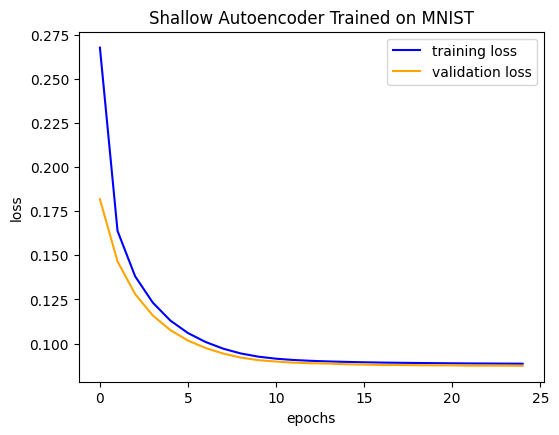

In [14]:
save_path = file_prefix + "/checkpoints/" + file_name + ".json"
with open(save_path, "r") as f:
  history = json.load(f)
fig, ax = loss_plot(history = history, title = "Shallow Autoencoder Trained on MNIST")

Let's recreate our test images and generate a few random comparisons to see how our autoencoder does:

In [15]:
# reload the model in case the notebook has been restarted
model = functional_shallow_autoencoder(image_dim, encoder_dim, optimizer)
model.load_weights(checkpoint_path)
# generate predictions
X_hat = model.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


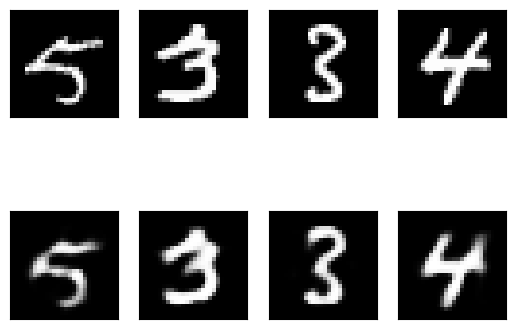

In [16]:
plot_rand_images(X_test, X_hat, num_rand = 4, ref_size = [28, 28], recr_size = [28, 28])

## Model Subclassing

We will now build another shallow autoencoder using model subclassing in Keras.

In [17]:
class Autoencoder(Model):
  def __init__(self, image_dim, latent_dim):
    super(Autoencoder, self).__init__()
    self.image_dim = image_dim
    self.latent_dim = latent_dim
    self.encoder = Dense(units = latent_dim, activation = "relu")
    self.decoder = Dense(units = image_dim, activation = "sigmoid")
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [18]:
model = Autoencoder(image_dim, encoder_dim)
optimizer = Adam(learning_rate = learning_rate)
model.compile(optimizer = optimizer,
              loss = "binary_crossentropy")
history = model.fit(X_train,
                    X_train,
                    epochs = epochs,
                    batch_size = batch_size,
                    shuffle = True,
                    validation_data = (X_test, X_test),
                    callbacks = [cp_callback])

Epoch 1/25
231/235 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3819
Epoch 1: saving model to /content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/autoencoders/checkpoints/autoencoder_ae1.weights.h5
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.3796 - val_loss: 0.1849
Epoch 2/25
231/235 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1751
Epoch 2: saving model to /content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/autoencoders/checkpoints/autoencoder_ae1.weights.h5
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.1749 - val_loss: 0.1482
Epoch 3/25
232/235 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1447
Epoch 3: saving model to /content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/autoencoders/checkpoints/autoencoder_ae1.weights.h5
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms

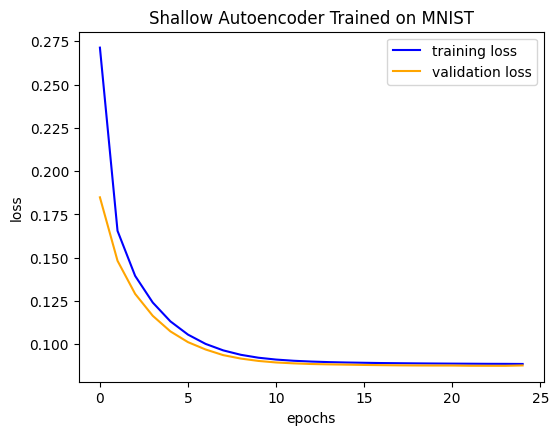

In [19]:
fig, ax = loss_plot(history = history.history, title = "Shallow Autoencoder Trained on MNIST")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


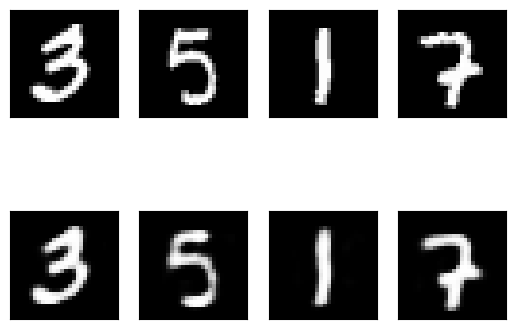

In [20]:
X_hat = model.predict(X_test)
plot_rand_images(X_test, X_hat, num_rand = 4, ref_size = [28, 28], recr_size = [28, 28])

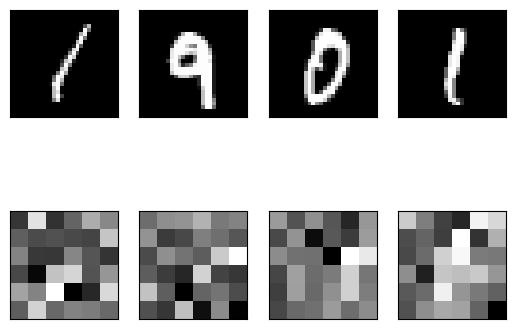

In [21]:
encoded_images = model.encoder(X_test).numpy()
plot_rand_images(X_test, encoded_images, num_rand = 4, ref_size = [28, 28], recr_size = [6, 6])

## Deep Convolutional Autoencoder

As a final step, let's build a deep convolutional autoencoder using the model subclassing framework.

In [23]:
class CNN_autoencoder(Model):
  def __init__(self):
    super(CNN_autoencoder, self).__init__()
    self.encoder = Sequential([Input(shape = (28, 28, 1)),
                               Conv2D(16, (3, 3), activation = "relu",
                                      padding = "same", strides = 1),
                               Conv2D(8, (3, 3), activation = "relu",
                                      padding = "same", strides = 1)])
    self.decoder = Sequential([Conv2DTranspose(8, (3, 3), activation = "relu",
                                               padding = "same", strides = 1),
                               Conv2DTranspose(16, (3, 3), activation = "relu",
                                               padding = "same", strides = 1),
                               Conv2D(1, (3, 3), activation = "sigmoid",
                                      padding = "same")])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [33]:
file_name = "autoencoder_cnnae1"
checkpoint_path = file_prefix + "/checkpoints/" + file_name + ".weights.h5"
cp_callback = ModelCheckpoint(filepath = checkpoint_path,
                              save_weights_only = True,
                              verbose = 1)

In [43]:
cnn_autoencoder = CNN_autoencoder()
optimizer = Adam(learning_rate = learning_rate)
cnn_autoencoder.compile(optimizer = optimizer,
                        loss = "mse")
X_train = X_train.reshape((len(X_train), 28, 28, 1))
X_test = X_test.reshape((len(X_test), 28, 28, 1))
X_train.shape
history = cnn_autoencoder.fit(X_train,
                              X_train,
                              epochs = 10,
                              batch_size = batch_size,
                              shuffle = True,
                              validation_data = (X_test, X_test),
                              callbacks = [cp_callback])

Epoch 1/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - loss: 0.0893
Epoch 1: saving model to /content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/autoencoders/checkpoints/autoencoder_cnnae1.weights.h5
235/235 ━━━━━━━━━━━━━━━━━━━━ 129s 525ms/step - loss: 0.0891 - val_loss: 0.0010
Epoch 2/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - loss: 8.0562e-04
Epoch 2: saving model to /content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/autoencoders/checkpoints/autoencoder_cnnae1.weights.h5
235/235 ━━━━━━━━━━━━━━━━━━━━ 133s 565ms/step - loss: 8.0509e-04 - val_loss: 5.1352e-04
Epoch 3/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - loss: 4.8687e-04
Epoch 3: saving model to /content/drive/Othercomputers/My MacBook Pro/portfolio/arpogg24.github.io/machine-learning/IBM-Machine-Learning/deep-learning/autoencoders/checkpoints/autoencoder_cnnae1.weights.h5
2

In [44]:
save_path = file_prefix + "/checkpoints/" + file_name + ".json"
with open(save_path, "w") as f:
  json.dump(history.history, f, indent = 4)

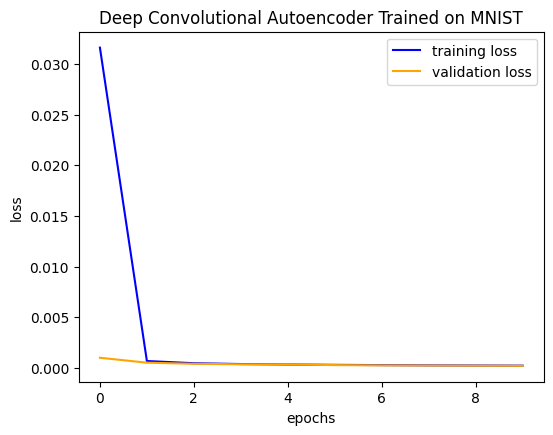

In [45]:
save_path = file_prefix + "/checkpoints/" + file_name + ".json"
with open(save_path, "r") as f:
  history = json.load(f)
fig, ax = loss_plot(history = history, title = "Deep Convolutional Autoencoder Trained on MNIST")

In [46]:
# reload the model in case the notebook has been restarted
model = CNN_autoencoder()
model.load_weights(checkpoint_path)
# generate predictions
X_hat = model.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step


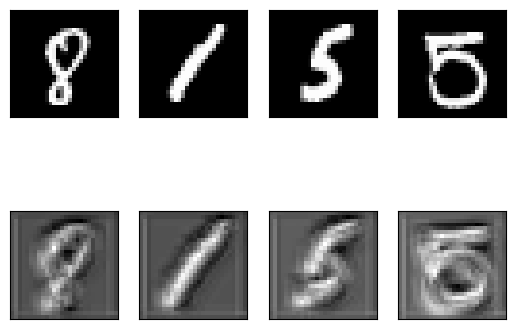

In [47]:
plot_rand_images(X_test, X_hat, num_rand = 4, ref_size = [28, 28], recr_size = [28, 28])